# Import các thư viện cần thiết

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import string
import re
from tqdm import tqdm
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# TF-IDF from scratch

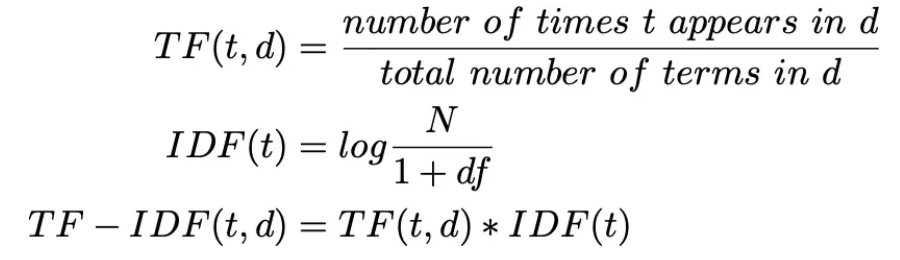

In [ ]:
sentences = [
    "The weather is beautiful today.",
    "I like to drink coffee in the morning.",
    "Have you finished your homework?",
    "Let's go to the movies this weekend.",
    "My cat is very cute.",
    "Programming is an important skill.",
    "Can you help me a little?",
    "This book is very interesting.",
    "I want to travel around the world.",
    "Dinner was delicious tonight."
]

## Tokenize các câu và xây dựng tập từ vựng

In [ ]:
def tokenize(sentence):
  return sentence.lower().split()

vocab = set()
tokenized_sentences = []
for sentence in sentences:
  tokenized_sentence = tokenize(sentence)
  tokenized_sentences.append(tokenized_sentence)
  vocab.update(tokenized_sentence)

vocab = sorted(vocab)
vocab_index = {word: idx for idx, word in enumerate(vocab)}

## Tính TF

In [ ]:
def compute_tf(tokens, vocab_index):
  tf = np.zeros(len(vocab_index))
  for token in tokens:
    if token in vocab_index:
      tf[vocab_index[token]] += 1
  return tf / len(tokens)

tf_matrix = np.array([compute_tf(tokens, vocab_index) for tokens in tokenized_sentences])

## Tính IDF

In [ ]:
def compute_idf(tokenized_sentences, vocab_index):
  idf = np.zeros(len(vocab_index))
  total_docs = len(tokenized_sentences)
  for tokens in tokenized_sentences:
    for word in set(tokens):
      if word in vocab_index:
        idf[vocab_index[word]] += 1
  return np.log(total_docs / (1 + idf))

idf = compute_idf(tokenized_sentences, vocab_index)

In [ ]:
tf_idf = tf_matrix * idf

In [ ]:
vocab

['a',
 'an',
 'around',
 'beautiful',
 'book',
 'can',
 'cat',
 'coffee',
 'cute.',
 'delicious',
 'dinner',
 'drink',
 'finished',
 'go',
 'have',
 'help',
 'homework?',
 'i',
 'important',
 'in',
 'interesting.',
 'is',
 "let's",
 'like',
 'little?',
 'me',
 'morning.',
 'movies',
 'my',
 'programming',
 'skill.',
 'the',
 'this',
 'to',
 'today.',
 'tonight.',
 'travel',
 'very',
 'want',
 'was',
 'weather',
 'weekend.',
 'world.',
 'you',
 'your']

In [ ]:
tf_idf[0]

array([0.        , 0.        , 0.        , 0.32188758, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.13862944, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.13862944, 0.        , 0.        , 0.32188758,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.32188758, 0.        , 0.        , 0.        , 0.        ])

# Ứng dụng word accouting model cho bài toán phân loại spam email

## Load dataset

In [3]:
data_path = '/content/drive/MyDrive/[TA] Falcon/Lesson 1/Lab 02/spam_ham_dataset.csv'
data = pd.read_csv(data_path)
data = data[['text', 'label']]
data.head()

,text,label
0,Subject: enron methanol ; meter # : 988291\r\n...,ham
1,"Subject: hpl nom for january 9 , 2001\r\n( see...",ham
2,"Subject: neon retreat\r\nho ho ho , we ' re ar...",ham
3,"Subject: photoshop , windows , office . cheap ...",spam
4,Subject: re : indian springs\r\nthis deal is t...,ham


In [4]:
data['label'].value_counts()

,count
label,
ham,3672
spam,1499


In [5]:
data['label'] = data['label'].map({'ham': 0, 'spam': 1})

In [6]:
data.head()

,text,label
0,Subject: enron methanol ; meter # : 988291\r\n...,0
1,"Subject: hpl nom for january 9 , 2001\r\n( see...",0
2,"Subject: neon retreat\r\nho ho ho , we ' re ar...",0
3,"Subject: photoshop , windows , office . cheap ...",1
4,Subject: re : indian springs\r\nthis deal is t...,0


## Chia tập dữ liệu

In [ ]:
# X_train, X_test, y_train, y_test = train_test_split(data['text'], data['label'], test_size=0.2, random_state=42)

In [7]:
train_data, test_data= train_test_split(data, test_size=0.2, random_state=42)

In [8]:
train_data['label'].value_counts()

,count
label,
0,2930
1,1206


In [9]:
spam_data = train_data[train_data['label'] == 1]
ham_data = train_data[train_data['label'] == 0]

# Giảm số lượng 'ham' cho bằng 'spam'
ham_sampled = ham_data.sample(n=len(spam_data), random_state=42)

# Ghép lại
balanced_data = pd.concat([spam_data, ham_sampled]).sample(frac=1, random_state=42).reset_index(drop=True)
train_data = balanced_data
print(train_data['label'].value_counts())

label
0    1206
1    1206
Name: count, dtype: int64


In [10]:
train_data.shape

(2412, 2)

In [11]:
X_train, y_train, X_test, y_test = train_data['text'], train_data['label'], test_data['text'], test_data['label']

## Sử dụng TF-IDF

In [12]:
tfidf_vectorizer = TfidfVectorizer(max_features=5000, tokenizer=lambda x: x, preprocessor=lambda x: x, token_pattern=None)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

In [20]:
nb_tfidf = SVC()
nb_tfidf.fit(X_train_tfidf, y_train)
y_pred_tfidf = nb_tfidf.predict(X_test_tfidf)
report_tfidf = classification_report(y_test, y_pred_tfidf)
print(report_tfidf)

              precision    recall  f1-score   support

           0       0.97      0.85      0.91       742
           1       0.71      0.92      0.81       293

    accuracy                           0.87      1035
   macro avg       0.84      0.89      0.86      1035
weighted avg       0.89      0.87      0.88      1035



## Sử dụng Bag-of-words

In [14]:
count_vectorizer = CountVectorizer()
X_train_counts = count_vectorizer.fit_transform(X_train)
X_test_counts = count_vectorizer.transform(X_test)

In [21]:
nb_counts = SVC()
nb_counts.fit(X_train_counts, y_train)
y_pred_counts = nb_counts.predict(X_test_counts)
report_counts = classification_report(y_test, y_pred_counts)
print(report_counts)

              precision    recall  f1-score   support

           0       1.00      0.86      0.93       742
           1       0.74      1.00      0.85       293

    accuracy                           0.90      1035
   macro avg       0.87      0.93      0.89      1035
weighted avg       0.93      0.90      0.90      1035



## Vẽ biểu đồ

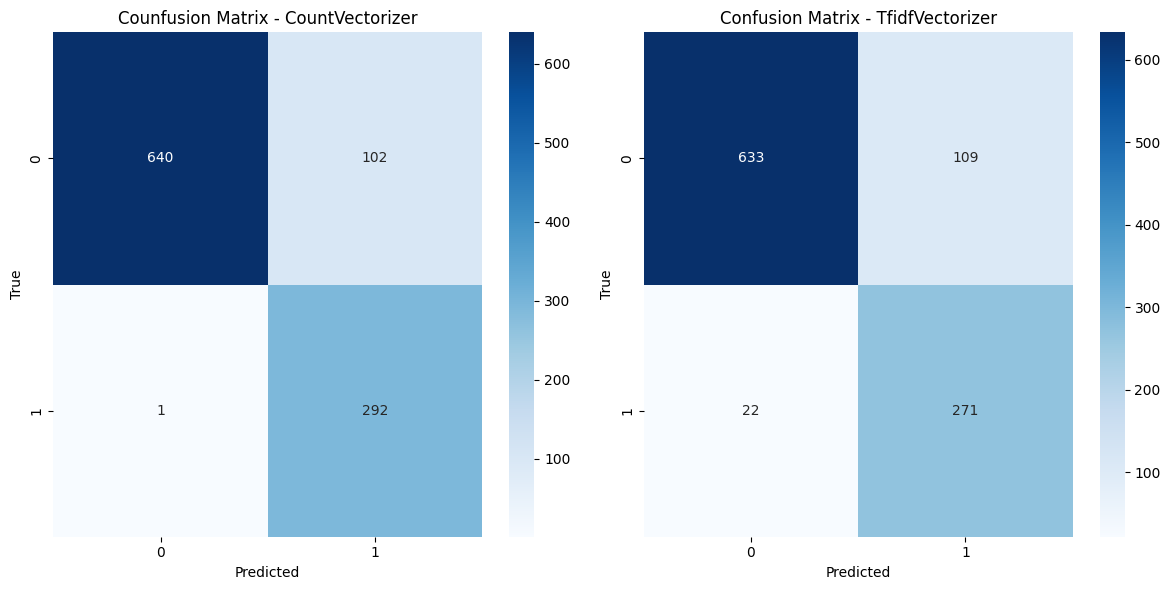

In [22]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

cm_counts = confusion_matrix(y_test, y_pred_counts)
sns.heatmap(cm_counts, annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title('Counfusion Matrix - CountVectorizer')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('True')

cm_tfidf = confusion_matrix(y_test, y_pred_tfidf)
sns.heatmap(cm_tfidf, annot=True, fmt='d', cmap='Blues', ax=axes[1])
axes[1].set_title('Confusion Matrix - TfidfVectorizer')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('True')

plt.tight_layout()
plt.show()